# Seizure Detection Using LFP and AUX Data: Feature Extraction, Windowing, and Modeling

## Initial Setup

### Import Libaries

In [1]:
import pandas as pd
import numpy as np
from scipy.signal import welch, get_window
import h5py

### Load EEG Data

In [2]:
# Path to the .mat file
mat_file_path = '/Users/hyojin/Desktop/Dr.Kim/2000Hz/POST_KA_F1_2024-10-03_12-02-32_2000Hz.mat'

# Load .mat file using h5py for MATLAB v7.3 format
with h5py.File(mat_file_path, 'r') as mat_file:
    eeg_data = np.array(mat_file['eegData']).T  # Transpose to get shape (channels, time)
    print(f"LFP data shape: {eeg_data.shape}")

LFP data shape: (32, 7226368)


### Set Parameters

In [3]:
# Sampling frequency
fs = 2000  # Brainstorm sampling rate in Hz

# Define frequency bands (Brainstorm custom bands)
bands = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'slowgamma': (30, 50),
    'fastgamma': (50, 100)
}

# Define PSD computation parameters
window_length = 2 * fs  # 2-second window
noverlap = window_length // 2  # 50% overlap
window = get_window('hamming', window_length)  # Hamming window


## PSD by Channels

### Initialize Storage for PSD Results

In [4]:
# Initialize dictionary to store band PSD values for all channels
all_band_psd = {band: [] for band in bands}

### Compute PSD for Each Channel

In [5]:
# Process each channel
for channel_idx, channel_data in enumerate(eeg_data):
    print(f"Processing channel {channel_idx + 1}/{eeg_data.shape[0]}...")

    # Calculate PSD for the channel using Welch's method
    f, psd = welch(channel_data, fs, window=window, nperseg=window_length, noverlap=noverlap, scaling='density')

    # Convert PSD to V²/Hz
    psd_in_v2 = psd / 1e12  # Convert from μV²/Hz to V²/Hz

    # Calculate mean PSD values for each frequency band
    for band_name, (f_low, f_high) in bands.items():
        band_indices = (f >= f_low) & (f <= f_high)
        band_mean_psd = np.mean(psd_in_v2[band_indices])  # Mean power in the band
        all_band_psd[band_name].append(band_mean_psd)


Processing channel 1/32...
Processing channel 2/32...
Processing channel 3/32...
Processing channel 4/32...
Processing channel 5/32...
Processing channel 6/32...
Processing channel 7/32...
Processing channel 8/32...
Processing channel 9/32...
Processing channel 10/32...
Processing channel 11/32...
Processing channel 12/32...
Processing channel 13/32...
Processing channel 14/32...
Processing channel 15/32...
Processing channel 16/32...
Processing channel 17/32...
Processing channel 18/32...
Processing channel 19/32...
Processing channel 20/32...
Processing channel 21/32...
Processing channel 22/32...
Processing channel 23/32...
Processing channel 24/32...
Processing channel 25/32...
Processing channel 26/32...
Processing channel 27/32...
Processing channel 28/32...
Processing channel 29/32...
Processing channel 30/32...
Processing channel 31/32...
Processing channel 32/32...


### Create and Save Results DataFrame

In [6]:
# Create a DataFrame from the results
df_psd = pd.DataFrame(all_band_psd)
df_psd.index = [f'Channel {i + 1}' for i in range(eeg_data.shape[0])]

# Display the DataFrame
print("\nPSD DataFrame (in V²/Hz):")
print(df_psd)

# Optionally save the DataFrame to a CSV file
output_csv_path = '/Users/hyojin/Desktop/Dr.Kim/Dataframe/psd_results.csv'
df_psd.to_csv(output_csv_path, index=True)
print(f"PSD results saved to {output_csv_path}")



PSD DataFrame (in V²/Hz):
                   delta         theta         alpha          beta  \
Channel 1   8.294086e-10  8.499354e-10  4.242239e-10  1.064887e-10   
Channel 2   1.007884e-09  8.071698e-10  3.902247e-10  1.014948e-10   
Channel 3   7.802081e-10  6.769099e-10  2.833583e-10  7.612191e-11   
Channel 4   6.323113e-10  4.142907e-10  1.561729e-10  6.940777e-11   
Channel 5   5.528189e-10  3.539774e-10  1.304999e-10  8.187581e-11   
Channel 6   5.844934e-10  3.929478e-10  1.412840e-10  7.866987e-11   
Channel 7   6.191199e-10  4.802829e-10  1.729627e-10  7.424383e-11   
Channel 8   5.831706e-10  4.656315e-10  1.711259e-10  7.221924e-11   
Channel 9   4.886232e-10  3.979951e-10  1.479549e-10  6.148308e-11   
Channel 10  3.615709e-10  2.694394e-10  1.046918e-10  4.364246e-11   
Channel 11  3.612931e-10  2.364182e-10  9.233531e-11  3.942741e-11   
Channel 12  2.894793e-10  1.635650e-10  6.160566e-11  2.729561e-11   
Channel 13  4.075702e-10  1.909168e-10  7.025429e-11  3.030316e

## PSD by 2s window with 50% overlap in one channel(in CA1 area)

### Select and Process Channel 14

In [7]:
# Select channel 14 (Python is 0-indexed, so index 13)
channel_idx = 13
channel_data = eeg_data[channel_idx, :]

# Calculate PSD for the channel using Welch's method
f, psd = welch(
    channel_data,
    fs,
    window=window,
    nperseg=window_length,
    noverlap=noverlap,
    scaling='density',
    return_onesided=True,
)

# Convert PSD to V²/Hz (assuming input data is in μV²/Hz)
psd_in_v2 = psd / 1e12  # Convert from μV²/Hz to V²/Hz


### Compute PSD for 2-Second Windows

In [8]:
# Split the signal into windows and compute PSD for each window
n_samples = len(channel_data)
step_size = window_length // 2
start_indices = np.arange(0, n_samples - window_length + 1, step_size)

# Store results in a DataFrame
rows = []
for start in start_indices:
    segment = channel_data[start:start + window_length]
    f, psd = welch(
        segment,
        fs,
        window=window,
        nperseg=window_length,
        noverlap=0,  # No additional overlap for this small segment
        scaling='density',
        return_onesided=True,
    )
    psd_in_v2 = psd / 1e12  # Convert from μV²/Hz to V²/Hz

    # Calculate mean PSD values for each frequency band
    row = {}
    for band_name, (f_low, f_high) in bands.items():
        band_indices = (f >= f_low) & (f <= f_high)
        row[band_name] = np.mean(psd_in_v2[band_indices])  # Mean power in the band
    rows.append(row)


### Create and Save Results DataFrame

In [9]:
# Create a DataFrame for the PSD results
df_psd_windows = pd.DataFrame(rows)
df_psd_windows.index = [f"{i}-{i+2}s" for i in range(len(rows))]

# Display the DataFrame
print("\nPSD DataFrame for Channel 14 (in V²/Hz):")
print(df_psd_windows)

# Optionally save the DataFrame to a CSV file
output_csv_path = '/Users/hyojin/Desktop/Dr.Kim/Dataframe/psd_channel_14_results.csv'
df_psd_windows.to_csv(output_csv_path, index=True)
print(f"PSD results saved to {output_csv_path}")



PSD DataFrame for Channel 14 (in V²/Hz):
                   delta         theta         alpha          beta  \
0-2s        1.296095e-10  8.272787e-11  5.481415e-11  1.020236e-11   
1-3s        8.933175e-11  3.886463e-11  4.200742e-11  6.557095e-12   
2-4s        9.429272e-11  6.081005e-11  1.256227e-11  3.790954e-12   
3-5s        6.172540e-11  3.462074e-11  3.205453e-11  5.435092e-12   
4-6s        1.007293e-10  4.660595e-11  2.633302e-11  6.840848e-12   
...                  ...           ...           ...           ...   
3607-3609s  7.989599e-12  2.407828e-11  7.184758e-12  3.752749e-12   
3608-3610s  1.169585e-11  1.776070e-11  4.349808e-12  3.438552e-12   
3609-3611s  1.464331e-11  1.805011e-11  1.028822e-11  3.965792e-12   
3610-3612s  3.694198e-11  6.893713e-11  7.265149e-12  3.708445e-12   
3611-3613s  1.094592e-11  1.808587e-11  7.530704e-12  3.058804e-12   

               slowgamma     fastgamma  
0-2s        2.176803e-12  1.680003e-12  
1-3s        1.752939e-12  1.476147e

## LFP Feature Extraction: Signal Energy and RMS

In [15]:
# Function to compute RMS
def compute_rms(signal):
    return np.sqrt(np.mean(signal**2))

# Select Channel 14 (Python is 0-indexed, so Channel 14 is at index 13)
channel_idx = 13  # Adjusted for Python indexing
channel_data = eeg_data[channel_idx]

print(f"Processing additional features for Channel {channel_idx + 1}...")

# Compute signal energy
signal_energy = np.sum(channel_data**2) / len(channel_data)

# Compute RMS
rms_value = compute_rms(channel_data)

# Create a DataFrame for Channel 14 features
lfp_features = {
    'channel': f'Channel {channel_idx + 1}',
    'signal_energy': signal_energy,
    'rms': rms_value
}
df_channel_14_features = pd.DataFrame([lfp_features]).set_index('channel')

# Combine with existing PSD DataFrame (for Channel 14 only)
df_channel_14_psd = df_psd.iloc[[channel_idx]]  # Select PSD for Channel 14
df_combined_features_channel_14 = pd.concat([df_channel_14_psd, df_channel_14_features], axis=1)

# Display combined features DataFrame
print("\nCombined LFP Features for Channel 14:")
print(df_combined_features_channel_14)

# Optionally save combined features to a CSV
output_csv_path_combined = '/Users/hyojin/Desktop/Dr.Kim/Dataframe/combined_channel_14_features.csv'
df_combined_features_channel_14.to_csv(output_csv_path_combined, index=True)
print(f"Combined features for Channel 14 saved to {output_csv_path_combined}")

Processing additional features for Channel 14...

Combined LFP Features for Channel 14:
                   delta         theta         alpha          beta  \
Channel 14  3.211113e-10  1.638884e-10  6.139651e-11  2.720951e-11   

               slowgamma     fastgamma  signal_energy        rms  
Channel 14  1.040537e-11  3.816679e-12    3136.849496  56.007584  
Combined features for Channel 14 saved to /Users/hyojin/Desktop/Dr.Kim/Dataframe/combined_channel_14_features.csv


## Label Seizure Windows

In [19]:
# Define new seizure intervals in seconds
seizure_intervals = [
    (52 * 60 + 12, 52 * 60 + 15),  # 52:12 - 52:15
    (52 * 60 + 26, 52 * 60 + 29),  # 52:26 - 52:29
    (52 * 60 + 54, 52 * 60 + 56),  # 52:54 - 52:56
    (54 * 60 + 32, 54 * 60 + 34),  # 54:32 - 54:34
    (58 * 60 + 16, 58 * 60 + 21)   # 58:16 - 58:21
]

# Convert intervals to sample indices
seizure_intervals_samples = [
    (int(start * fs), int(end * fs)) for start, end in seizure_intervals
]

def label_window(start_sample, end_sample, intervals):
    """
    Determine if a given window overlaps with any seizure interval.

    Parameters:
    - start_sample: Start index of the window
    - end_sample: End index of the window
    - intervals: List of (start, end) intervals in samples

    Returns:
    - 1 if the window overlaps with any seizure interval, otherwise 0
    """
    for interval_start, interval_end in intervals:
        if start_sample < interval_end and end_sample > interval_start:
            return 1  # Seizure
    return 0  # Non-seizure

# Label each window in your data
window_labels = []  # To store labels for each window
for start_idx in start_indices:  
    end_idx = start_idx + window_length  # End index of the current window
    label = label_window(start_idx, end_idx, seizure_intervals_samples)
    window_labels.append(label)

# Add labels to the PSD DataFrame
df_psd_windows['label'] = window_labels

# Save the labeled DataFrame
output_csv_path_labeled = '/Users/hyojin/Desktop/Dr.Kim/Dataframe/psd_channel_labeled.csv'
df_psd_windows.to_csv(output_csv_path_labeled, index=True)
print(f"Labeled PSD results saved to {output_csv_path_labeled}")

# Display a preview of the labeled DataFrame
print("\nLabeled PSD DataFrame:")
print(df_psd_windows.head())

Labeled PSD results saved to /Users/hyojin/Desktop/Dr.Kim/Dataframe/psd_channel_labeled.csv

Labeled PSD DataFrame:
             delta         theta         alpha          beta     slowgamma  \
0-2s  1.296095e-10  8.272787e-11  5.481415e-11  1.020236e-11  2.176803e-12   
1-3s  8.933175e-11  3.886463e-11  4.200742e-11  6.557095e-12  1.752939e-12   
2-4s  9.429272e-11  6.081005e-11  1.256227e-11  3.790954e-12  2.523215e-12   
3-5s  6.172540e-11  3.462074e-11  3.205453e-11  5.435092e-12  2.413212e-12   
4-6s  1.007293e-10  4.660595e-11  2.633302e-11  6.840848e-12  3.162370e-12   

         fastgamma  label  
0-2s  1.680003e-12      0  
1-3s  1.476147e-12      0  
2-4s  1.214208e-12      0  
3-5s  1.086206e-12      0  
4-6s  1.045249e-12      0  


In [20]:
# Define seizure intervals in seconds
seizure_intervals = [
    (52 * 60 + 12, 52 * 60 + 15),  # 52:12 - 52:15
    (52 * 60 + 26, 52 * 60 + 29),  # 52:26 - 52:29
    (52 * 60 + 54, 52 * 60 + 56),  # 52:54 - 52:56
    (54 * 60 + 32, 54 * 60 + 34),  # 54:32 - 54:34
    (58 * 60 + 16, 58 * 60 + 21)   # 58:16 - 58:21
]

# Convert intervals to sample indices
seizure_intervals_samples = [
    (int(start * fs), int(end * fs)) for start, end in seizure_intervals
]

# Function to label windows
def label_window(start_sample, end_sample, intervals):
    """
    Determine if a given window overlaps with any seizure interval.

    Parameters:
    - start_sample: Start index of the window
    - end_sample: End index of the window
    - intervals: List of (start, end) intervals in samples

    Returns:
    - 1 if the window overlaps with any seizure interval, otherwise 0
    """
    for interval_start, interval_end in intervals:
        if start_sample < interval_end and end_sample > interval_start:
            return 1  # Seizure
    return 0  # Non-seizure

# Select Channel 14 (Python is 0-indexed, so Channel 14 is at index 13)
channel_idx = 13
channel_data = eeg_data[channel_idx]

# Initialize lists for storing results
window_labels = []  # Labels for each window
rms_values = []  # RMS for each window
signal_energies = []  # Signal energy for each window

# Process each window
for start_idx in start_indices:  
    end_idx = start_idx + window_length  # End index of the current window

    # Extract the window segment
    segment = channel_data[start_idx:end_idx]

    # Compute features for the window
    rms_value = np.sqrt(np.mean(segment**2))  # RMS
    signal_energy = np.sum(segment**2) / len(segment)  # Signal energy
    label = label_window(start_idx, end_idx, seizure_intervals_samples)  # Label the window

    # Append computed features and label to the respective lists
    rms_values.append(rms_value)
    signal_energies.append(signal_energy)
    window_labels.append(label)

# Add computed features and labels to the PSD DataFrame for Channel 14
df_psd_windows['rms'] = rms_values
df_psd_windows['signal_energy'] = signal_energies
df_psd_windows['label'] = window_labels

# Save the updated DataFrame to a CSV
output_csv_path_combined = '/Users/hyojin/Desktop/Dr.Kim/Dataframe/psd_channel_14_features.csv'
df_psd_windows.to_csv(output_csv_path_combined, index=True)
print(f"Combined PSD features, RMS, Signal Energy, and Labels saved to {output_csv_path_combined}")

# Display a preview of the updated DataFrame
print("\nUpdated PSD DataFrame with RMS, Signal Energy, and Labels:")
print(df_psd_windows.head())


Combined PSD features, RMS, Signal Energy, and Labels saved to /Users/hyojin/Desktop/Dr.Kim/Dataframe/psd_channel_14_features.csv

Updated PSD DataFrame with RMS, Signal Energy, and Labels:
             delta         theta         alpha          beta     slowgamma  \
0-2s  1.296095e-10  8.272787e-11  5.481415e-11  1.020236e-11  2.176803e-12   
1-3s  8.933175e-11  3.886463e-11  4.200742e-11  6.557095e-12  1.752939e-12   
2-4s  9.429272e-11  6.081005e-11  1.256227e-11  3.790954e-12  2.523215e-12   
3-5s  6.172540e-11  3.462074e-11  3.205453e-11  5.435092e-12  2.413212e-12   
4-6s  1.007293e-10  4.660595e-11  2.633302e-11  6.840848e-12  3.162370e-12   

         fastgamma  label        rms  signal_energy  
0-2s  1.680003e-12      0  33.107164    1096.084279  
1-3s  1.476147e-12      0  28.716709     824.649393  
2-4s  1.214208e-12      0  29.079905     845.640881  
3-5s  1.086206e-12      0  27.164337     737.901218  
4-6s  1.045249e-12      0  29.557374     873.638355  


### Check Labeling

In [12]:
import matplotlib.pyplot as plt

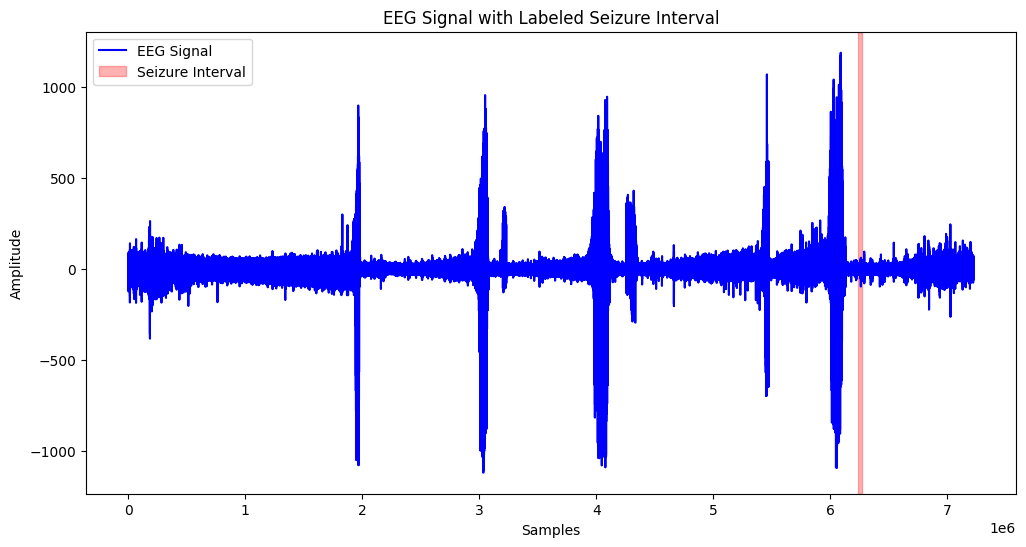

In [13]:
channel_idx = 13  # Channel 14 for example
plt.figure(figsize=(12, 6))
plt.plot(eeg_data[channel_idx, :], label="EEG Signal", color="blue")
plt.axvspan(52 * 60 * fs, 52 * 60 * fs + 15 * fs, color='red', alpha=0.3, label="Seizure Interval")
plt.title("EEG Signal with Labeled Seizure Interval")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

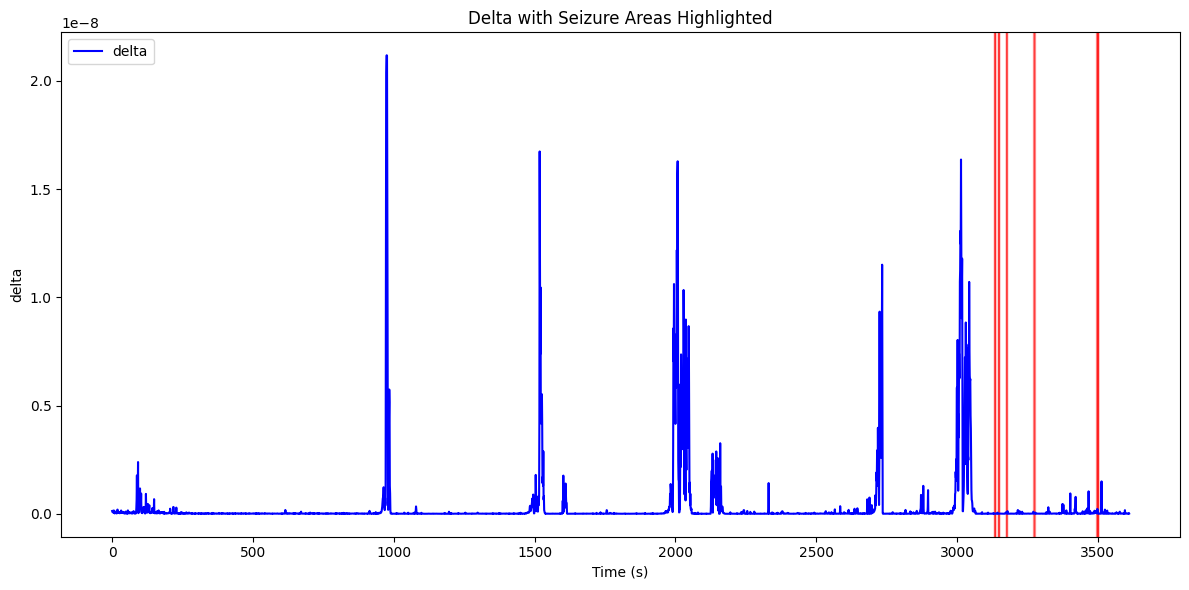

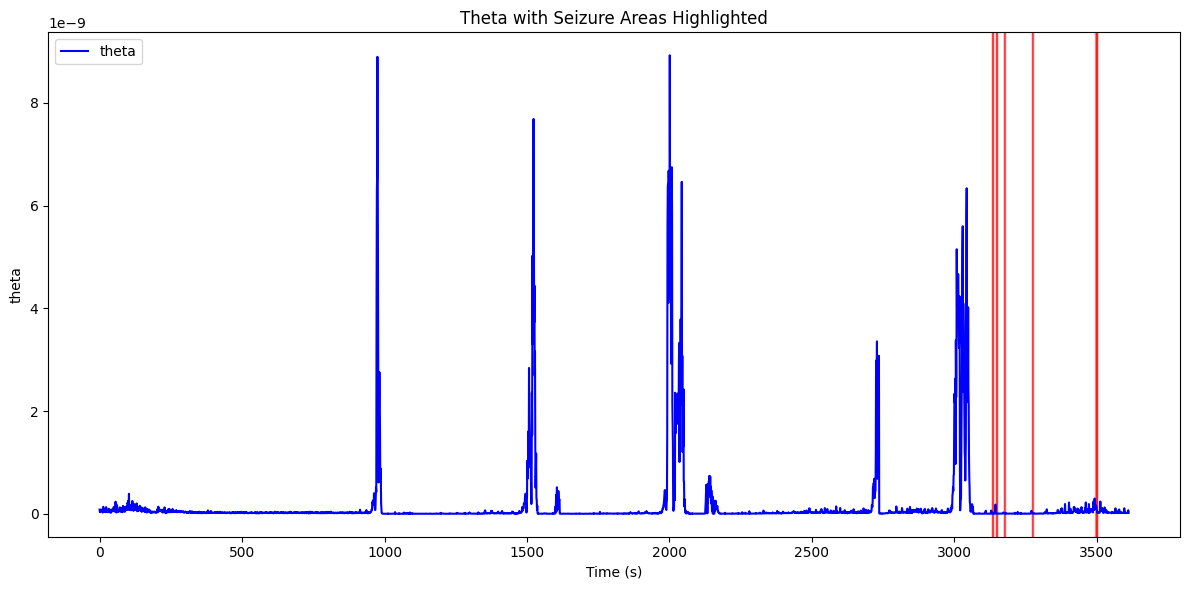

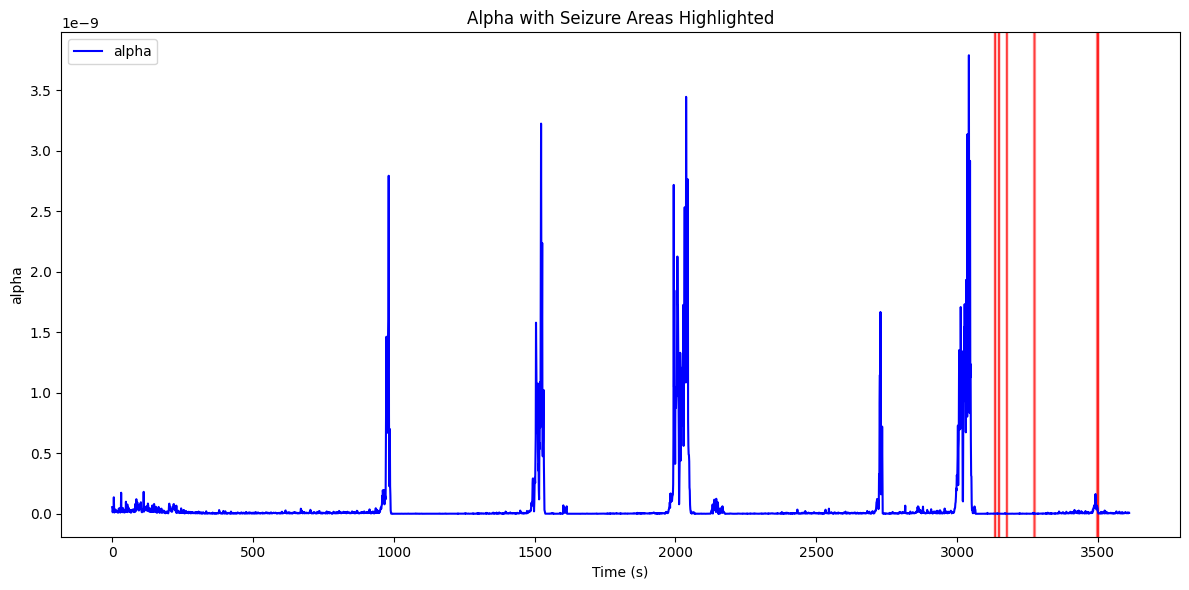

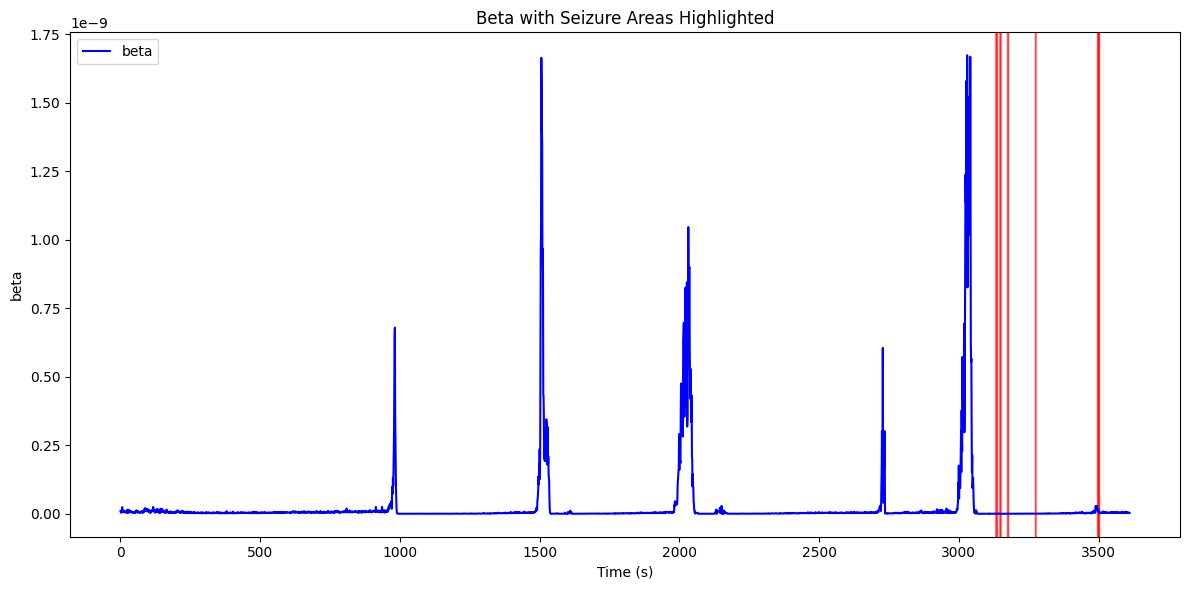

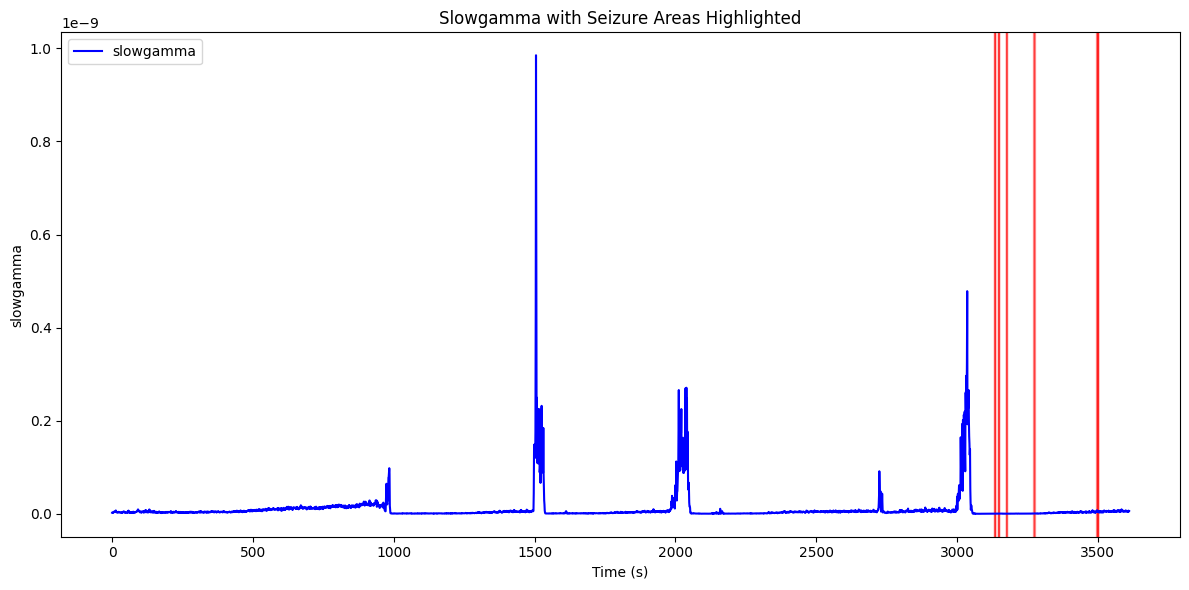

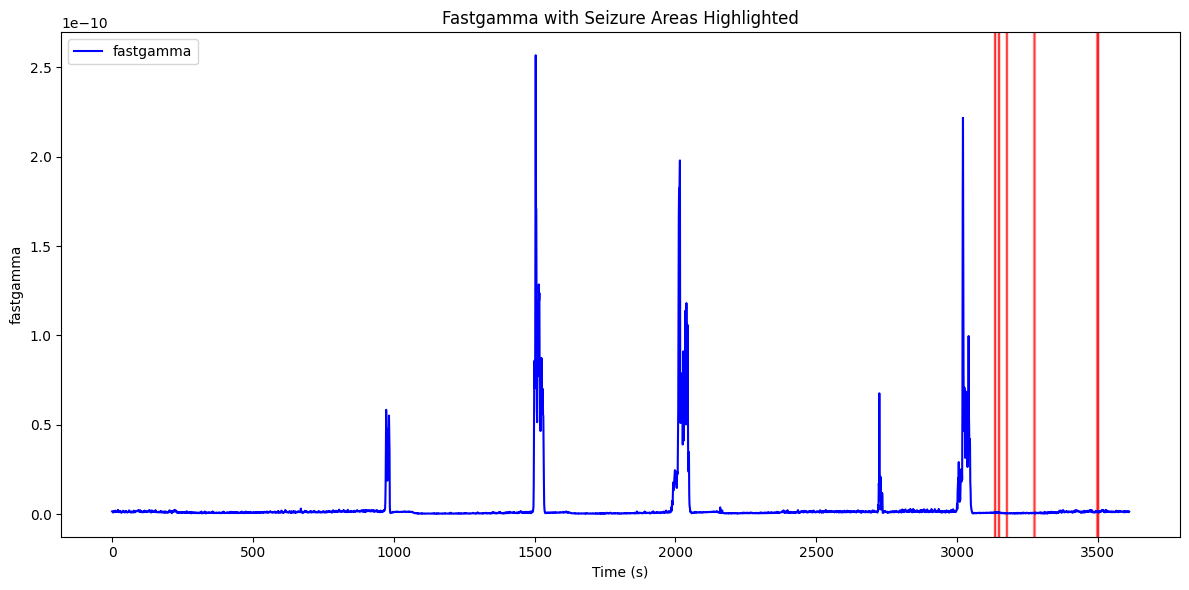

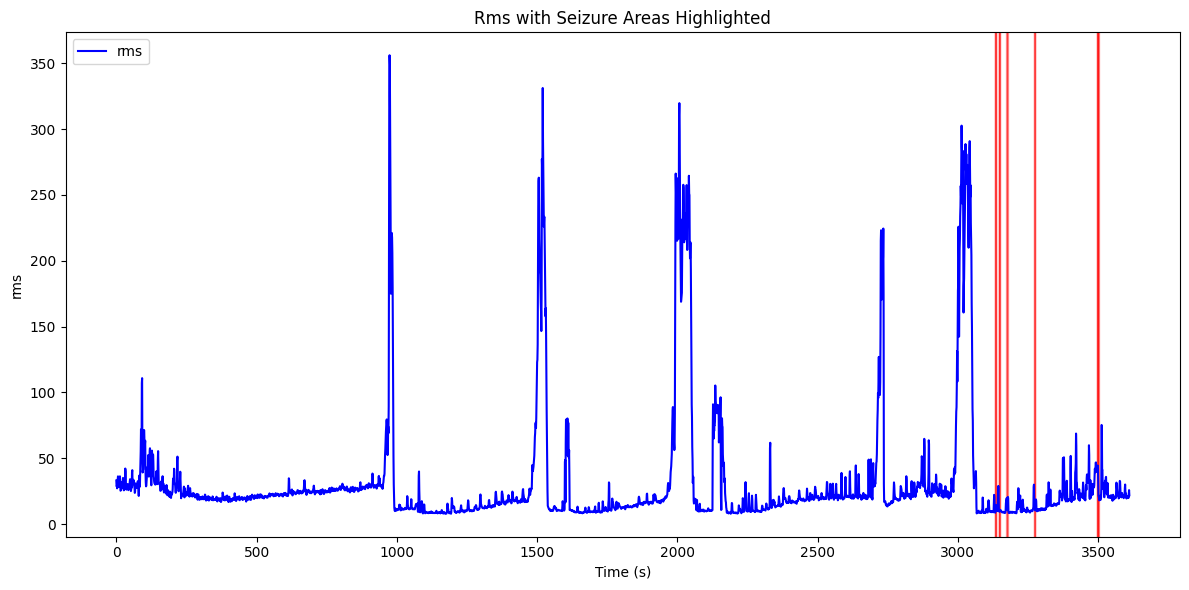

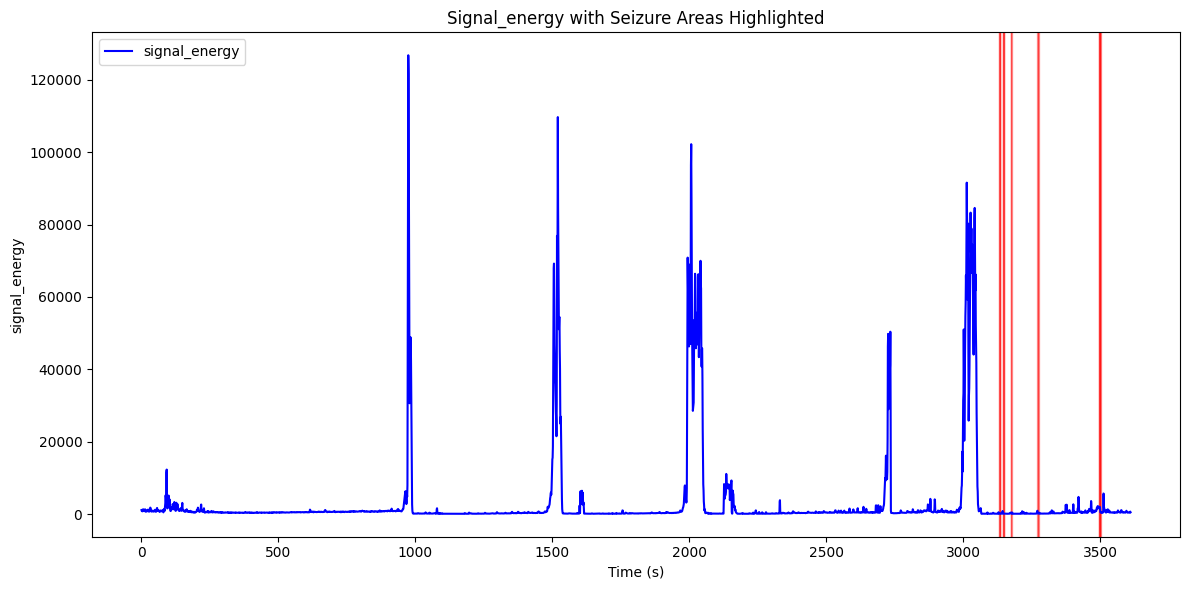

In [23]:
# Convert the index to numerical values (e.g., extract the start time from "0-2s")
df_psd_windows['numerical_index'] = [int(idx.split('-')[0]) for idx in df_psd_windows.index]

# List of columns to plot (exclude 'label' and 'numerical_index')
columns_to_plot = [col for col in df_psd_windows.columns if col not in ['label', 'numerical_index']]

# Plot each column
for column in columns_to_plot:
    plt.figure(figsize=(12, 6))

    # Plot the feature
    plt.plot(df_psd_windows['numerical_index'], df_psd_windows[column], label=column, color='blue')

    # Highlight seizure areas
    for i, row in df_psd_windows.iterrows():
        if row['label'] == 1:  # Check if this is a seizure area
            plt.axvspan(row['numerical_index'], row['numerical_index'] + 2, color='red', alpha=0.3)

    # Add labels and legend
    plt.title(f"{column.capitalize()} with Seizure Areas Highlighted")
    plt.xlabel("Time (s)")
    plt.ylabel(column)
    plt.legend()
    plt.tight_layout()
    plt.show()
